# Creación de modelos de puntuación del Riesgo de Impago

En esta aplicación implementaremos un modelo de puntuación de riesgo de impago siguiendo la metodología  que hemos analizado en la presentación de clase (selección de variables mediante valor de la información, tramificación de variables continuas, agrupación de categorías, transformación woe de variables, estimación de modelos de regresión logística, ....)

Existen diferentes librerías que incorporan funciones con los diferentes procedimientos ya programados que nos facilitan mucho la tarea. Una de estas librerías es `scorecardpy` [librería scorecardpy](https://pypi.org/project/scorecardpy/) que estima tarjetas de puntuación *lineales* utilizando regresiones logísticas. Esta librería nació inicialmente en R, y lamentablemente la versión de Python da algunos errores de adaptación a las últimas versiones de Pandas. Su desarrollador remite a utilizar la versión estable de R (librería en R 'scorecard'). 

Así que en su lugar de esta librería utilizaremos la librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/) que en realidad recoge (y en mi opinión mejora) la principal función de la librería `scorecardpy`  

## Creación de un entorno e instalación de librerías 



In [2]:
# Podemos Crear un nuevo entorno de trabajo (mejor desde el terminal)
#! conda create -n risk_env
#! conda activate risk_env
#! conda config --env --add channels conda-forge
#! conda config --env --set channel_priority strict

# Instalamos la librería pandas y seaborn en el nuevo entrono desde conda (sólo la primera vez, utilizaré el terminal (con jupiter debo utilizar !))
# conda install pandas
# conda install seaborn

# Instalamos la librería optbinning y scorecardpy (sólo la primera vez)
# ! pip install scorecardpy # NOOO esta no la intaleis porque no es estable
# ! pip install optbinning


#Cargo o importo pandas, numpy, Matplotlib, 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para el análisis descriptivo inicial de contraste de asociación importo el test Chi2 y el anova 
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Cargaríamos la librería scortecardpy si fuese estable (que no lo es)
#import scorecardpy as sc


# Librería para hacer la tramificación, agrupación y transformación WOE
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks


# Scikit-learn para dividir la muestra y para estimar el modelo de regresión logística (sólo si no se quiere utilizar
# la función optbinning.scorecard que ya lo incropora)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

(CVXPY) Feb 17 11:38:55 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 17 11:38:55 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [3]:
# Cargamos los datos germancredit que están precargados en la librería scorecardpy
dt=pd.read_excel('C:\\Users\\pablo\\OneDrive\\Documentos\\GitHub\\MasterBigDataML-DataMiningIII\\src\\data\\DatosPractica_Scoring.xlsx')

## Descripción inicial de los datos
Vamos a hacer una descripción inicial de los datos


In [4]:
#Información del Contenido
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1319 non-null   int64  
 1   Cardhldr  1285 non-null   float64
 2   default   994 non-null    float64
 3   Age       1319 non-null   float64
 4   Income    1319 non-null   float64
 5   Exp_Inc   1319 non-null   float64
 6   Avgexp    1319 non-null   float64
 7   Ownrent   1319 non-null   int64  
 8   Selfempl  1319 non-null   int64  
 9   Depndt    1319 non-null   int64  
 10  Inc_per   1319 non-null   float64
 11  Cur_add   1319 non-null   int64  
 12  Major     1319 non-null   int64  
 13  Active    1319 non-null   int64  
dtypes: float64(7), int64(7)
memory usage: 144.4 KB


## Variable objetivo: default

In [5]:
dt["Cardhldr"].value_counts()


Cardhldr
1.0    994
0.0    291
Name: count, dtype: int64

In [6]:
df_aceptados = dt[dt["Cardhldr"] == 1]

In [7]:
df_aceptados["Cardhldr"].value_counts()

Cardhldr
1.0    994
Name: count, dtype: int64

# Proceso de tramificación, agrupación y trasformación WOE Completo

Para no ir variable a variable se puede hacer todo el proceso completo

Proceso Entero



In [44]:
# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = df_aceptados['default'].values
X = df_aceptados.drop(columns=['Cardhldr','ID', 'default'])
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [45]:
X

,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
0,27.08333,2.4000,0.016798,33.01333,0,0,0,2.400000,56,1,1
1,24.25000,3.5000,0.069963,203.89170,0,0,0,3.500000,60,1,11
3,40.33333,3.0670,0.159700,408.08250,0,0,2,1.022333,18,0,0
4,28.16667,3.3500,0.071625,199.36920,1,0,0,3.350000,18,1,2
6,23.25000,1.8769,0.353630,553.10670,0,0,0,1.876900,12,1,3
...,...,...,...,...,...,...,...,...,...,...,...
1278,41.66667,2.4752,0.067250,138.54670,0,0,2,0.825067,222,0,10
1280,40.66667,5.0500,0.028428,119.30170,1,0,0,5.050000,128,1,10
1282,44.66667,2.4000,0.000500,0.00000,0,0,0,2.400000,36,1,11
1283,47.41667,4.9200,0.044894,183.89830,1,1,1,2.460000,288,1,14


In [46]:
# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02}  # no imponemos "max": 1}
}

In [47]:
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

In [48]:
list_categorical

[]

In [49]:
list_variables

['Age',
 'Income',
 'Exp_Inc',
 'Avgexp',
 'Ownrent',
 'Selfempl',
 'Depndt',
 'Inc_per',
 'Cur_add',
 'Major',
 'Active']

In [50]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 1284
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       994 non-null    float64
 1   Income    994 non-null    float64
 2   Exp_Inc   994 non-null    float64
 3   Avgexp    994 non-null    float64
 4   Ownrent   994 non-null    int64  
 5   Selfempl  994 non-null    int64  
 6   Depndt    994 non-null    int64  
 7   Inc_per   994 non-null    float64
 8   Cur_add   994 non-null    int64  
 9   Major     994 non-null    int64  
 10  Active    994 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 93.2 KB


In [52]:
Y.shape

(994,)

In [53]:
# 4) Obtenemos los tramos optimos de todas las Variables
df_aceptados_binned = binning_process.fit(X, Y)

In [54]:
df_aceptados_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
6,Depndt,numerical,OPTIMAL,False,4,0.005121,0.00064,0.035048,0.000135
5,Selfempl,numerical,OPTIMAL,False,2,0.011895,0.001478,0.028111,0.005643
4,Ownrent,numerical,OPTIMAL,False,2,0.011976,0.001496,0.054689,0.02354
9,Major,numerical,OPTIMAL,True,2,0.030557,0.003792,0.059399,0.039958
7,Inc_per,numerical,OPTIMAL,True,7,0.15624,0.018334,0.183395,0.025607
2,Exp_Inc,numerical,OPTIMAL,True,5,0.187134,0.02197,0.191595,0.194671
8,Cur_add,numerical,OPTIMAL,True,6,0.192857,0.023537,0.232347,0.002619
1,Income,numerical,OPTIMAL,True,5,0.222999,0.026768,0.215741,0.055953
0,Age,numerical,OPTIMAL,True,7,0.224977,0.026616,0.236603,0.021707
3,Avgexp,numerical,OPTIMAL,True,7,0.271663,0.031598,0.243863,0.018436


# Estimación del Modelo

Ahora podemos calcular la tarjeta de puntuación. En los apuntes de clase definimos tanto los WOE, como los Odd ratio como la probabilidad de `evento` respecto al `no-evento` (malos clientes o impago=1 respecto a los buenos clientes o impago=0):

$$ odd = {{P}\over {(1-P)}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$
 
 Y la fórmula para obtener la puntuación o los score debe ser una relación negativa con los odd ratio: cuanto mayor la probabilidad de impago (en relación a la de no impago), menor puntuación ha de tener: 

 $$ score {= offset - Factor}~·~{ln(odds)}$$

Para pasar de Probabiliddes de impago a Puntuaciones, habrá que establecer tanto el valor de `offset` como el de `Factor`. Esto se hace de manera arbitraria dependiendo de cada institución financiera.

En general, para determinar estos dos valores es necesario establecer la pendiente de la recta y un punto de la misma.

En cuanto a la pendiente, cuanto más plana sea la pendiente, menor variabilidad tendrán los valores de puntuación de crédito que se alcancen, y al revés, cuanto mayor pendiente más diferencias en la puntuación final. Yo voy a utilizar un apendiente (arbitraria) estableciendo de forma arbitraria cada cuantos puntos de score (**pdo_0**) se dobla el odd ratio: $ score - pdo_0 = {offset -Factor}~ ·{ln(2*odds)}$.

 En cuanto al punto de la recta (arbitrario), puede hacerse estableciento (de manera arbitraria) la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* (**odds_0**)
 
 Así habría que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40  (esto es que cada 40 puntos de calidad creditica se dobla el odd-ratio))
* **scorecard_points** =600  (alguien con calidad crediticia muy buena, de sobresaliente, sacaría 600 puntos)
* **odds_0** =1/50  (odd ratio que se considera de sobresaliente)

La librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/), en realidad utiliza el módulo de `credit scoring` de `SAS-miner` como inspiración, y por eso define al revés tanto los WOE como los odd ratio, es decir `no-evento` en relación a `evento` (clientes buenos respecto a los malos, o no-impago respecto a impago, impago=0 respecto a impago=1). 
$$ odd^B = {{(1-P)}\over {P}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

Esto implica que la ecuación que transforma las probabilidades de impago en scores utilizando esta *odds<sup>B</sup>* debe tener pendiente positiva (cuanto mejor *odd<sup>B</sup>* mejor calidad crediticia tiene el cliente)

 $$ score= {offset + Factor} ~·~ {ln(odds^B)}$$
 
 Nótese que ahora habrá que establecer de nuevo los puntos de score que doblan el odd ratio (**pdo_0**), y también la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* **odds_0 <sup>*B*</sup>**, con **odds_0 <sup>*B*</sup>** **= 1/odds_0**.

 Así para estimar la puntuación crediticia con `optBinning` hay que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0 <sup>*B*</sup>** = 50  (equivalente a **odds_0** =1/50 )




In [55]:

# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         selection_criteria={'iv': {'min': 0.02}},
                                         variable_names=['Age', 'Income',
                                                         'Exp_Inc', 'Avgexp',
                                                         'Ownrent', 'Selfempl',
                                                         'Depndt', 'Inc_per',
                                                         'Cur_add', 'Major',
                                                         'Active']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [56]:
tarjeta.information(print_level=2)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                  pdo_odds   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                    994
    Number of variables                   11
    Target type                       binary

    Number of numerical                   11
    Number of categorical                  0
    Number of selected                     8

  Timing
    Total time                          1.04 sec
    Binning process                     0.99 sec   ( 95.38%)
    Estimator                           0.03 sec   (  2.46%

In [57]:
tarjeta.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,Age,0,"(-inf, 21.9583)",79,0.079477,73,6,0.075949,0.351869,0.008561,0.001065,-0.473521,71.662201
1,Age,1,"[21.9583, 26.3750)",220,0.221328,206,14,0.063636,0.541988,0.052489,0.006482,-0.473521,76.857367
2,Age,2,"[26.3750, 27.7083)",54,0.054326,53,1,0.018519,1.823461,0.091055,0.010028,-0.473521,111.874749
3,Age,3,"[27.7083, 29.1250)",72,0.072435,66,6,0.083333,0.251065,0.004134,0.000515,-0.473521,68.907624
4,Age,4,"[29.1250, 35.6250)",223,0.224346,197,26,0.116592,-0.121723,0.003488,0.000436,-0.473521,58.720861
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Active,4,"[9.5000, 11.5000)",83,0.083501,72,11,0.132530,-0.268060,0.006667,0.000831,-0.879064,48.448699
5,Active,5,"[11.5000, 18.5000)",168,0.169014,135,33,0.196429,-0.738063,0.122240,0.014942,-0.879064,24.605957
6,Active,6,"[18.5000, inf)",55,0.055332,42,13,0.236364,-0.974110,0.075795,0.009117,-0.879064,12.631567
7,Active,7,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.879064,62.047059


In [58]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)


0.10462

# Inferencia de rechazados


In [59]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1319 non-null   int64  
 1   Cardhldr  1285 non-null   float64
 2   default   994 non-null    float64
 3   Age       1319 non-null   float64
 4   Income    1319 non-null   float64
 5   Exp_Inc   1319 non-null   float64
 6   Avgexp    1319 non-null   float64
 7   Ownrent   1319 non-null   int64  
 8   Selfempl  1319 non-null   int64  
 9   Depndt    1319 non-null   int64  
 10  Inc_per   1319 non-null   float64
 11  Cur_add   1319 non-null   int64  
 12  Major     1319 non-null   int64  
 13  Active    1319 non-null   int64  
dtypes: float64(7), int64(7)
memory usage: 144.4 KB


In [67]:
dt_aceptados_rechazados = dt[dt["Cardhldr"].notna()]
dt_aceptados_rechazados

,ID,Cardhldr,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
0,1,1.0,0.0,27.08333,2.400,0.016798,33.01333,0,0,0,2.400000,56,1,1
1,2,1.0,1.0,24.25000,3.500,0.069963,203.89170,0,0,0,3.500000,60,1,11
2,3,0.0,NaN,27.41667,1.600,0.000750,0.00000,1,0,1,0.800000,30,0,0
3,4,1.0,0.0,40.33333,3.067,0.159700,408.08250,0,0,2,1.022333,18,0,0
4,5,1.0,0.0,28.16667,3.350,0.071625,199.36920,1,0,0,3.350000,18,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,1281,1.0,0.0,40.66667,5.050,0.028428,119.30170,1,0,0,5.050000,128,1,10
1281,1282,0.0,NaN,22.50000,1.800,0.000667,0.00000,0,0,2,0.600000,4,1,0
1282,1283,1.0,0.0,44.66667,2.400,0.000500,0.00000,0,0,0,2.400000,36,1,11
1283,1284,1.0,0.0,47.41667,4.920,0.044894,183.89830,1,1,1,2.460000,288,1,14


In [69]:
X_inferencia = dt_aceptados_rechazados[dt_aceptados_rechazados["default"].isna()]
X_inferencia = X_inferencia.drop(columns=['Cardhldr', 'default'])
X_inferencia


,ID,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
2,3,27.41667,1.600,0.000750,0.0,1,0,1,0.800,30,0,0
5,6,34.25000,1.944,0.000617,0.0,0,0,1,0.972,54,1,1
8,9,22.66667,1.500,0.000800,0.0,0,0,3,0.375,14,1,4
12,13,34.75000,2.670,0.000449,0.0,0,0,0,2.670,51,1,25
15,16,41.83333,3.500,0.000343,0.0,0,0,0,3.500,54,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1271,1272,23.83333,2.550,0.000471,0.0,1,0,2,0.850,24,1,0
1273,1274,56.00000,1.450,0.000828,0.0,1,0,0,1.450,242,1,4
1276,1277,29.50000,3.000,0.000400,0.0,1,0,2,1.000,60,1,8
1279,1280,19.50000,1.560,0.000769,0.0,1,0,0,1.560,46,0,3


Usamos como threshold la media de Valores en Y para los casos anteriores

In [70]:
Y.mean()

0.10462776659959759

In [71]:
Y_pred=tarjeta.predict_proba(X_inferencia.drop(columns='ID'))[:,1]
Y_pred

array([0.00255396, 0.01129307, 0.03322324, 0.23573372, 0.01962843,
       0.05505438, 0.03670735, 0.00611876, 0.0102738 , 0.07515987,
       0.12218065, 0.01123056, 0.14691472, 0.0978072 , 0.14566018,
       0.05843497, 0.07180383, 0.05257818, 0.161359  , 0.23897152,
       0.16949067, 0.02510054, 0.03742981, 0.01462434, 0.0645348 ,
       0.00447327, 0.0060762 , 0.09626127, 0.21762263, 0.07703041,
       0.05374858, 0.00906348, 0.01051416, 0.18928975, 0.0401956 ,
       0.01251703, 0.0159752 , 0.01071472, 0.00526894, 0.00928789,
       0.0739024 , 0.00827268, 0.0030167 , 0.00619091, 0.11110719,
       0.13568317, 0.00436298, 0.07497848, 0.09288685, 0.280482  ,
       0.00500416, 0.16949067, 0.03822279, 0.14032708, 0.07216429,
       0.01770259, 0.0036578 , 0.00607396, 0.02493073, 0.00628492,
       0.11690063, 0.04531613, 0.07345097, 0.01039001, 0.12505977,
       0.00830967, 0.15883698, 0.00285772, 0.00970925, 0.00342838,
       0.15619916, 0.09418918, 0.00519183, 0.00570868, 0.00844

In [73]:
# Umbral definido para la clasificación
umbral = 0.10462776659959759

# Transformar los valores según el umbral
Y_pred_transformado = (Y_pred > umbral).astype(float)

Y_pred_transformado

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0.

In [75]:
X_inferencia['default'] = Y_pred_transformado
X_inferencia

,ID,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active,default
2,3,27.41667,1.600,0.000750,0.0,1,0,1,0.800,30,0,0,0.0
5,6,34.25000,1.944,0.000617,0.0,0,0,1,0.972,54,1,1,0.0
8,9,22.66667,1.500,0.000800,0.0,0,0,3,0.375,14,1,4,0.0
12,13,34.75000,2.670,0.000449,0.0,0,0,0,2.670,51,1,25,1.0
15,16,41.83333,3.500,0.000343,0.0,0,0,0,3.500,54,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,1272,23.83333,2.550,0.000471,0.0,1,0,2,0.850,24,1,0,0.0
1273,1274,56.00000,1.450,0.000828,0.0,1,0,0,1.450,242,1,4,0.0
1276,1277,29.50000,3.000,0.000400,0.0,1,0,2,1.000,60,1,8,0.0
1279,1280,19.50000,1.560,0.000769,0.0,1,0,0,1.560,46,0,3,0.0


In [76]:
# Concatenar X_inferencia y X por filas
X_combinado = pd.concat([X_inferencia, X], ignore_index=True)

# Mostrar el DataFrame resultante
print(X_combinado)


        ID       Age  Income   Exp_Inc    Avgexp  Ownrent  Selfempl  Depndt  \
0      3.0  27.41667  1.6000  0.000750    0.0000        1         0       1   
1      6.0  34.25000  1.9440  0.000617    0.0000        0         0       1   
2      9.0  22.66667  1.5000  0.000800    0.0000        0         0       3   
3     13.0  34.75000  2.6700  0.000449    0.0000        0         0       0   
4     16.0  41.83333  3.5000  0.000343    0.0000        0         0       0   
...    ...       ...     ...       ...       ...      ...       ...     ...   
1280   NaN  41.66667  2.4752  0.067250  138.5467        0         0       2   
1281   NaN  40.66667  5.0500  0.028428  119.3017        1         0       0   
1282   NaN  44.66667  2.4000  0.000500    0.0000        0         0       0   
1283   NaN  47.41667  4.9200  0.044894  183.8983        1         1       1   
1284   NaN  37.08333  5.4900  0.160214  732.9792        1         0       1   

       Inc_per  Cur_add  Major  Active  default  
0

In [77]:
# Paso 1: Marcar las filas en dt para actualización usando 'ID'
ids_para_actualizar = X_inferencia['ID']

# Paso 2: Actualizar dt basado en las correspondencias de 'ID' con X_inferencia
for id_actualizar in ids_para_actualizar:
    dt.loc[dt['ID'] == id_actualizar, ['default']] = X_inferencia.loc[X_inferencia['ID'] == id_actualizar, ['default']].values

# Mostrar dt actualizado
print(dt)

        ID  Cardhldr  default       Age  Income   Exp_Inc      Avgexp  \
0        1       1.0      0.0  27.08333   2.400  0.016798   33.013330   
1        2       1.0      1.0  24.25000   3.500  0.069963  203.891700   
2        3       0.0      0.0  27.41667   1.600  0.000750    0.000000   
3        4       1.0      0.0  40.33333   3.067  0.159700  408.082500   
4        5       1.0      0.0  28.16667   3.350  0.071625  199.369200   
...    ...       ...      ...       ...     ...       ...         ...   
1314  1315       NaN      NaN  53.25000   3.960  0.002424    7.083333   
1315  1316       NaN      NaN  30.25000   4.506  0.133742  502.201700   
1316  1317       NaN      NaN  27.91667   3.960  0.012576   40.833330   
1317  1318       NaN      NaN  46.41667   3.500  0.109643  319.792500   
1318  1319       NaN      NaN  31.08333   1.515  0.000792    0.000000   

      Ownrent  Selfempl  Depndt   Inc_per  Cur_add  Major  Active  
0           0         0       0  2.400000       56     

Inferencia de Rechazados terminada, tomo ahora como X los aceptados y rechazados con todos los valores de default previos e inferidos.

In [78]:
dt_aceptados_rechazados = dt[dt["Cardhldr"].notna()]
dt_aceptados_rechazados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1285 entries, 0 to 1284
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1285 non-null   int64  
 1   Cardhldr  1285 non-null   float64
 2   default   1285 non-null   float64
 3   Age       1285 non-null   float64
 4   Income    1285 non-null   float64
 5   Exp_Inc   1285 non-null   float64
 6   Avgexp    1285 non-null   float64
 7   Ownrent   1285 non-null   int64  
 8   Selfempl  1285 non-null   int64  
 9   Depndt    1285 non-null   int64  
 10  Inc_per   1285 non-null   float64
 11  Cur_add   1285 non-null   int64  
 12  Major     1285 non-null   int64  
 13  Active    1285 non-null   int64  
dtypes: float64(7), int64(7)
memory usage: 150.6 KB


Pasos restantes: 

1. Separar en entrenamiento y test.
2. El binning + modelos
3. Determinar punto de corte del threshold
4. Probar sobre test
5. Probar sobre datos nuevos y contestar pregunta

1. Separar en entrenamiento y test:

In [91]:
dt_train, dt_test = train_test_split(dt_aceptados_rechazados,stratify=dt_aceptados_rechazados["default"], test_size=.25, random_state=1234)

In [92]:
dt_train["default"].shape

(963,)

In [93]:
dt_train["default"].mean()

0.12876427829698858

In [94]:
dt_test["default"].shape

(322,)

In [95]:
dt_test["default"].mean()

0.12732919254658384

In [96]:
# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = dt_train['default'].values
X = dt_train.drop(columns=['Cardhldr','ID', 'default'])
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

2. Binning + modelos

In [97]:
X.isna().sum()

Age         0
Income      0
Exp_Inc     0
Avgexp      0
Ownrent     0
Selfempl    0
Depndt      0
Inc_per     0
Cur_add     0
Major       0
Active      0
dtype: int64

In [98]:
Y

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [99]:
# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02}  # no imponemos "max": 1}
}

In [100]:
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

In [101]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

In [102]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
5,Selfempl,numerical,OPTIMAL,False,2,0.006771,0.000844,0.021964,0.003069
9,Major,numerical,OPTIMAL,False,2,0.012087,0.001508,0.040774,0.014491
6,Depndt,numerical,OPTIMAL,False,4,0.018248,0.002275,0.066487,0.003789
4,Ownrent,numerical,OPTIMAL,True,2,0.044815,0.005591,0.10556,0.118609
7,Inc_per,numerical,OPTIMAL,True,7,0.193242,0.022084,0.200238,0.005341
3,Avgexp,numerical,OPTIMAL,True,6,0.238183,0.027826,0.235159,0.347245
8,Cur_add,numerical,OPTIMAL,True,7,0.249857,0.02997,0.244704,0.004674
1,Income,numerical,OPTIMAL,True,5,0.332884,0.039429,0.282681,0.196022
0,Age,numerical,OPTIMAL,True,8,0.347793,0.041419,0.298502,0.000389
2,Exp_Inc,numerical,OPTIMAL,True,8,0.405915,0.046575,0.304731,0.043224


In [103]:
# Ahora aplicaríamos la misma transformación pero al conjunto de test (si hubiera que puntuar a nuevos clientes haríamos lo mismo)

Y_test = dt_test['default'].values
X_test = dt_test.drop(columns=['Cardhldr','ID', 'default']) #todas menos la primera que es el ID y la variable y

dt_test_woe=dt_train_binned.transform(X_test, metric="woe")
dt_test_woe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, 251 to 519
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      322 non-null    float64
 1   Income   322 non-null    float64
 2   Exp_Inc  322 non-null    float64
 3   Avgexp   322 non-null    float64
 4   Ownrent  322 non-null    float64
 5   Inc_per  322 non-null    float64
 6   Cur_add  322 non-null    float64
 7   Active   322 non-null    float64
dtypes: float64(8)
memory usage: 22.6 KB


In [104]:

# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         selection_criteria={'iv': {'min': 0.02}},
                                         variable_names=['Age', 'Income',
                                                         'Exp_Inc', 'Avgexp',
                                                         'Ownrent', 'Selfempl',
                                                         'Depndt', 'Inc_per',
                                                         'Cur_add', 'Major',
                                                         'Active']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [105]:
tarjeta.information(print_level=2)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                  pdo_odds   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                    963
    Number of variables                   11
    Target type                       binary

    Number of numerical                   11
    Number of categorical                  0
    Number of selected                     8

  Timing
    Total time                          0.92 sec
    Binning process                     0.88 sec   ( 96.35%)
    Estimator                           0.01 sec   (  1.00%

In [106]:
tarjeta.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,Age,0,"(-inf, 21.9583)",67,0.069574,63,4,0.059701,0.844911,0.036189,0.004394,-0.521638,85.783881
1,Age,1,"[21.9583, 25.0417)",144,0.149533,139,5,0.034722,1.413107,0.177134,0.020466,-0.521638,102.888054
2,Age,2,"[25.0417, 28.1250)",150,0.155763,137,13,0.086667,0.443102,0.025900,0.003211,-0.521638,73.688387
3,Age,3,"[28.1250, 32.4583)",159,0.165109,137,22,0.138365,-0.082991,0.001173,0.000147,-0.521638,57.851611
4,Age,4,"[32.4583, 35.1250)",79,0.082035,68,11,0.139241,-0.090317,0.000692,0.000086,-0.521638,57.631078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,Active,3,"[10.5000, 13.5000)",98,0.101765,75,23,0.234694,-0.729935,0.070141,0.008578,-0.986807,18.782637
4,Active,4,"[13.5000, 17.5000)",68,0.070613,46,22,0.323529,-1.174330,0.143964,0.017028,-0.986807,-6.524071
5,Active,5,"[17.5000, inf)",67,0.069574,43,24,0.358209,-1.328783,0.189082,0.022037,-0.986807,-15.319599
6,Active,6,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.986807,60.349847


In [107]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)


0.12876

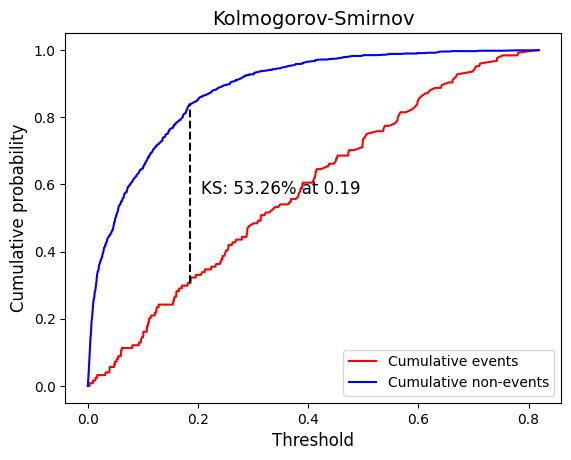

In [108]:
plot_ks(Y, Y_pred)

El punto de corte que maximiza el f1_score es:  0.24
y el máximo se alcanza en  0.536


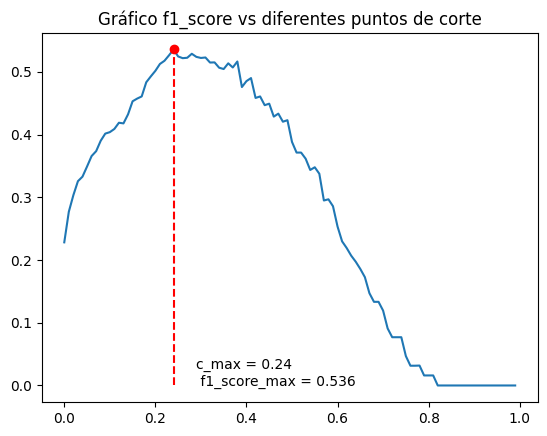

In [110]:
# También puede utilizarse el máximo del f1_score
# definimos un vector de puntos de corte
c=np.arange(0,1,0.01)
# calculamos el f1_score para cada punto de corte
f1_score_ = [f1_score(dt_train["default"],np.multiply(Y_pred>c_,1)) for c_ in c]
# obtenemos el punto de corte que maximiza el f1_score
c_max = c[np.argmax(f1_score_)]
print("El punto de corte que maximiza el f1_score es: ", c_max)
print("y el máximo se alcanza en ", np.max(f1_score_).round(3))

# hacemos un gráfico de c y los f1_score correspondientes
plt.plot(c,f1_score_)
plt.stem(c_max, np.max(f1_score_),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico f1_score vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n f1_score_max = "+str(np.max(f1_score_).round(3)))
plt.show()

El punto de corte que maximiza el índice de Youden es:  0.24
y el máximo se alcanza en  0.527


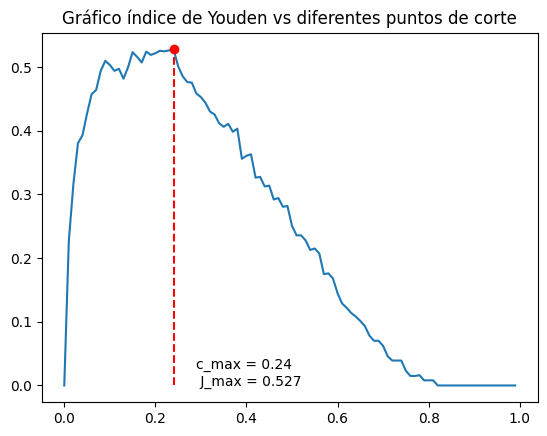

In [112]:
# método de Youden (J) para obtener el punto de corte óptimo
# definimos un vector de puntos de corte (c) y de probabilidad de aceptación (p)
c=np.arange(0,1,0.01)

# Calculamos el estadístico J de Youden para cada punto de corte= Sensibilidad + Especificidad -1
J= [balanced_accuracy_score(dt_train["default"],np.multiply(Y_pred>c_,1), adjusted=True) for c_ in c ]
# obtenemos el punto de corte que maximiza el índice de Youden
c_max = c[np.argmax(J)]
print("El punto de corte que maximiza el índice de Youden es: ", c_max)
print("y el máximo se alcanza en ", np.max(J).round(3))

# gráfico de c y los índices de Youden correspondientes
plt.plot(c,J)
plt.stem(c_max, np.max(J),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico índice de Youden vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n J_max = "+str(np.max(J).round(3)))
plt.show()

In [116]:
# Voy a utilizar simplemente la frecuencia observada
Prob_Corte=0.24
print(Prob_Corte)

0.24


In [117]:
dt_train["Y_pronostico"]=np.multiply(Y_pred>Prob_Corte,1)

In [118]:
pd.crosstab(dt_train["default"],dt_train["Y_pronostico"],margins=True, normalize=1).round(3)


Y_pronostico,0,1,All
default,,,
0.0,0.943,0.538,0.871
1.0,0.057,0.462,0.129


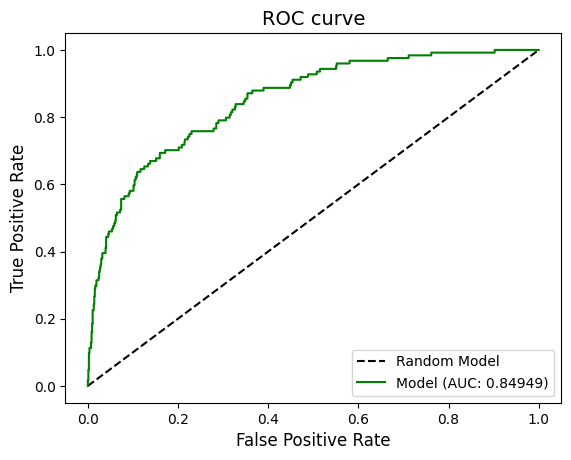

In [119]:
plot_auc_roc(Y,Y_pred)

Reentrenamos con todos los datos y vemos para los nuevos valores:


In [121]:
# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = dt_aceptados_rechazados['default'].values
X = dt_aceptados_rechazados.drop(columns=['Cardhldr','ID', 'default'])
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [122]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

In [123]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
6,Depndt,numerical,OPTIMAL,False,4,0.001713,0.000214,0.020741,0.000007
5,Selfempl,numerical,OPTIMAL,False,2,0.001761,0.00022,0.010931,0.000497
9,Major,numerical,OPTIMAL,True,2,0.03758,0.004663,0.069859,0.06005
4,Ownrent,numerical,OPTIMAL,True,2,0.045657,0.005696,0.106548,0.122933
7,Inc_per,numerical,OPTIMAL,True,7,0.226136,0.025564,0.217083,0.020724
3,Avgexp,numerical,OPTIMAL,True,6,0.273135,0.032995,0.26382,0.250558
8,Cur_add,numerical,OPTIMAL,True,7,0.290147,0.035316,0.277668,0.010505
1,Income,numerical,OPTIMAL,True,5,0.301635,0.035885,0.270709,0.354386
0,Age,numerical,OPTIMAL,True,8,0.384241,0.045776,0.321006,0.00094
2,Exp_Inc,numerical,OPTIMAL,True,7,0.45395,0.052646,0.336937,0.447097


In [124]:

# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         selection_criteria={'iv': {'min': 0.02}},
                                         variable_names=['Age', 'Income',
                                                         'Exp_Inc', 'Avgexp',
                                                         'Ownrent', 'Selfempl',
                                                         'Depndt', 'Inc_per',
                                                         'Cur_add', 'Major',
                                                         'Active']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [125]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)


0.1284

El punto de corte que maximiza el índice de Youden es:  0.17
y el máximo se alcanza en  0.564


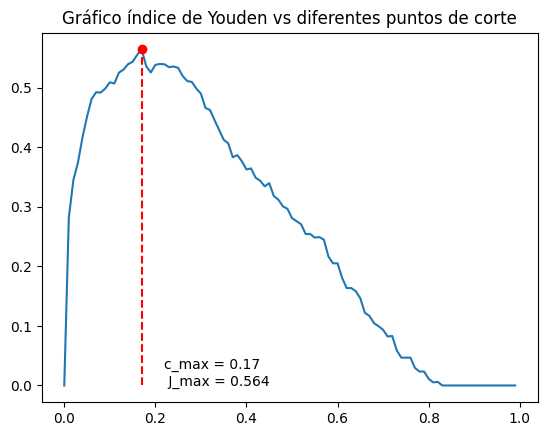

In [126]:
# método de Youden (J) para obtener el punto de corte óptimo
# definimos un vector de puntos de corte (c) y de probabilidad de aceptación (p)
c=np.arange(0,1,0.01)

# Calculamos el estadístico J de Youden para cada punto de corte= Sensibilidad + Especificidad -1
J= [balanced_accuracy_score(dt_aceptados_rechazados["default"],np.multiply(Y_pred>c_,1), adjusted=True) for c_ in c ]
# obtenemos el punto de corte que maximiza el índice de Youden
c_max = c[np.argmax(J)]
print("El punto de corte que maximiza el índice de Youden es: ", c_max)
print("y el máximo se alcanza en ", np.max(J).round(3))

# gráfico de c y los índices de Youden correspondientes
plt.plot(c,J)
plt.stem(c_max, np.max(J),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico índice de Youden vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n J_max = "+str(np.max(J).round(3)))
plt.show()

In [ ]:
# Voy a utilizar simplemente la frecuencia observada
Prob_Corte=0.17

Tomamos los valores nuevos del dataframe original

In [131]:
X_inferencia = dt[dt["default"].isna()]
X_inferencia = X_inferencia.drop(columns=['Cardhldr', 'default'])
X_inferencia

,ID,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
1285,1286,27.00000,2.6750,0.034820,77.286670,1,0,0,2.675000,135,1,0
1286,1287,27.58333,5.5000,0.220473,1010.502000,0,1,0,5.500000,72,1,11
1287,1288,31.25000,5.0000,0.074378,309.910000,1,0,2,1.666667,12,1,12
1288,1289,25.25000,2.8800,0.041061,98.464160,0,0,0,2.880000,7,1,0
1289,1290,30.00000,1.8500,0.107582,165.855000,0,0,0,1.850000,60,1,12
1290,1291,35.50000,5.5000,0.012896,58.608330,0,0,0,5.500000,36,1,2
1291,1292,33.25000,3.6000,0.025991,77.806660,0,0,3,0.900000,16,1,9
1292,1293,39.00000,3.5000,0.045145,131.674200,1,0,2,1.166667,113,0,13
1293,1294,40.75000,8.0000,0.046671,311.142500,1,0,2,2.666667,38,1,0
1294,1295,63.16667,5.5000,0.020482,93.625000,1,0,1,2.750000,192,1,15


In [135]:
Y_predicciones = tarjeta.predict_proba(X_inferencia.drop(columns=['ID']))[:,1]

In [136]:
# Transformar los valores según el umbral
Y_pred_transformado = (Y_predicciones > Prob_Corte).astype(float)

Y_pred_transformado

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [142]:
X_inferencia["predicciones"] = Y_pred_transformado
# Seleccionar las columnas 'ID' y 'predicciones' de X_inferencia
X_inferencia_seleccionadas = X_inferencia[['ID', 'predicciones']]
X_inferencia_seleccionadas

,ID,predicciones
1285,1286,0.0
1286,1287,1.0
1287,1288,0.0
1288,1289,0.0
1289,1290,1.0
1290,1291,0.0
1291,1292,0.0
1292,1293,0.0
1293,1294,0.0
1294,1295,1.0
